In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000-012.root"

In [2]:
import time
import os
from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')  # or ATLAS/LHCb2
import dask_awkward as dak

In [3]:
processor = wideband.DataProcessor(usexroot=True, treename='run', runlist=[1738], userunlist=False, remove=False)
filelist = processor.getFilelist(DATASET)
#append "run" at the end of each file name
filelist = ["{}{}".format(i, ":run") for i in filelist]

In [4]:
%%time
#List of variable to export to a skimmed array
varlist=['spillNumber', 'eventNumber','runNumber', 'subrunNumber',
         'trackPEs', 'trackPoints', 'trackChi2', 'trackIntercept', 'trackSlope']

all_layers = np.arange(0,16) 
test_layers = np.arange(3,7)
trig_layers = all_layers[~np.isin(all_layers, test_layers)]
varlist.extend(['nTrigHits'])
varlist.extend(['PEsTestLayers'])

ar_skim_list = []

for filename in filelist:
    print("Processing file: %s"%filename)
    file = uproot.open(filename)
    for ar in file.iterate(step_size="10MB", 
                                   filter_name=['PEs', varlist], 
                                   report=False, library='ak'):
        # Set PEs to zero for aging and quad-counters
        ak.to_numpy(ar['PEs'])[:,0,0:7] = 0
        ak.to_numpy(ar['PEs'])[:,3,0:7] = 0
        ak.to_numpy(ar['PEs'])[:,7,0:7] = 0
                
        # Filter out hits below 5PE
        ar_trig_filt = ak.where(ar['PEs'] >= 5, ar['PEs'], 0)       

        # Calculate PEs for even and odd layers
        PEs_even_layers = ak.sum(ar_trig_filt[:, :, 0:31], axis=-1).to_numpy()
        PEs_odd_layers = ak.sum(ar_trig_filt[:, :, 32:64], axis=-1).to_numpy()
        
        # Add PEs for even and odd layers to the original array
        ar['PEsAllLayer'] = np.hstack((PEs_even_layers, PEs_odd_layers))

        # Count the number of triggered layers
        ar['nTrigHits'] = ak.sum(ar['PEsAllLayer'][:, trig_layers] > 0, axis=-1)
        
        # Filter out events with less than 10 triggered hits
        ar = ar[ar['nTrigHits'] > 10]
        
        # Extract only PEsTestLayers to save memory
        ar['PEsTestLayers'] = ar['PEsAllLayer'][:, test_layers]
        
        # Append to the list
        ar_skim_list.append(ar[varlist])

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics-noadc/CRVWB-000-006-000/root/e9/92/rec.mu2e.CRV_wideband_cosmics-noadc.CRVWB-000-006-000.001720_000.root:run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics-noadc/CRVWB-000-006-000/root/0d/24/rec.mu2e.CRV_wideband_cosmics-noadc.CRVWB-000-006-000.001721_000.root:run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics-noadc/CRVWB-000-006-000/root/30/8d/rec.mu2e.CRV_wideband_cosmics-noadc.CRVWB-000-006-000.001721_001.root:run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics-noadc/CRVWB-000-006-000/root/e6/38/rec.mu2e.CRV_wideband_cosmics-noadc.CRVWB-000-006-000.001722_000.root:run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics-noadc/CRVWB-000-006-000/root/fe/cd/rec.mu2e.CRV_wideband_cosmics-noadc.CRVWB-000-006

In [5]:
ar_skim = ak.concatenate(ar_skim_list, axis=0)
ar_skim['nTestHits'] = ak.sum(ar_skim['PEsTestLayers'] > 0, axis=-1)

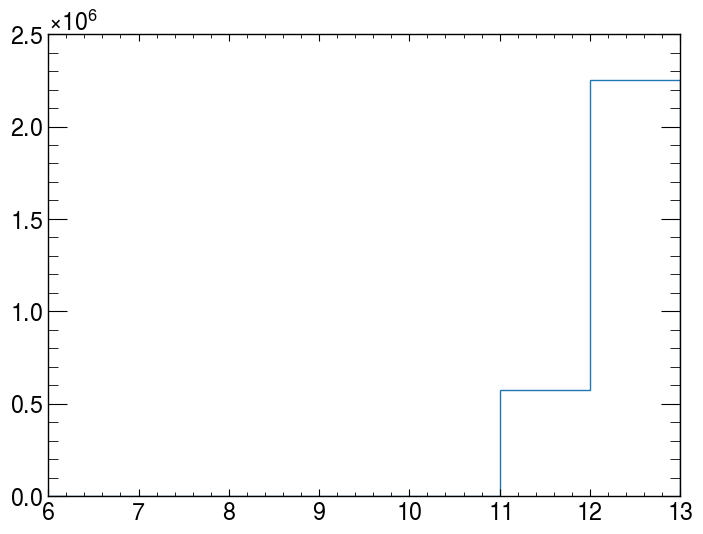

In [6]:
plt.hist(ar_skim['nTrigHits'], histtype='step', bins=7, range=(6,13));

Distributions before any cuts 

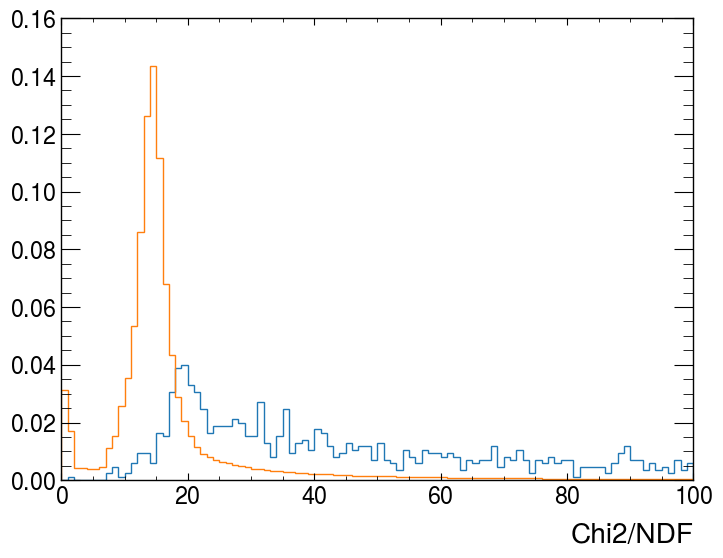

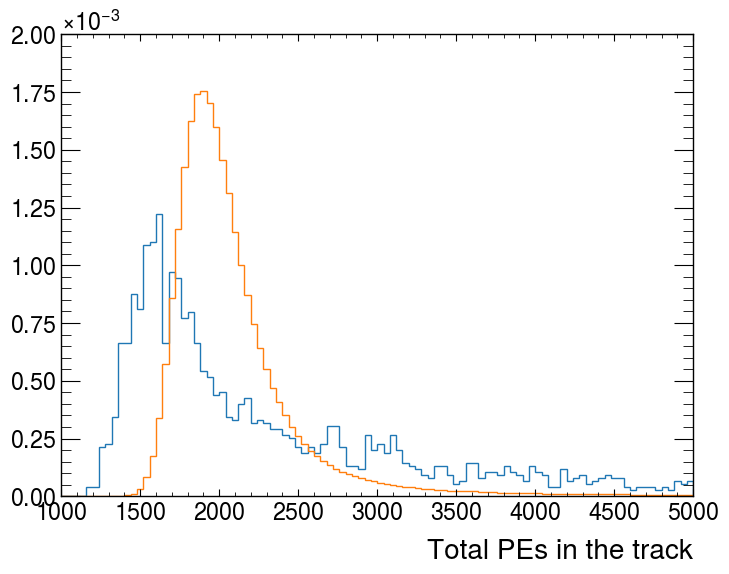

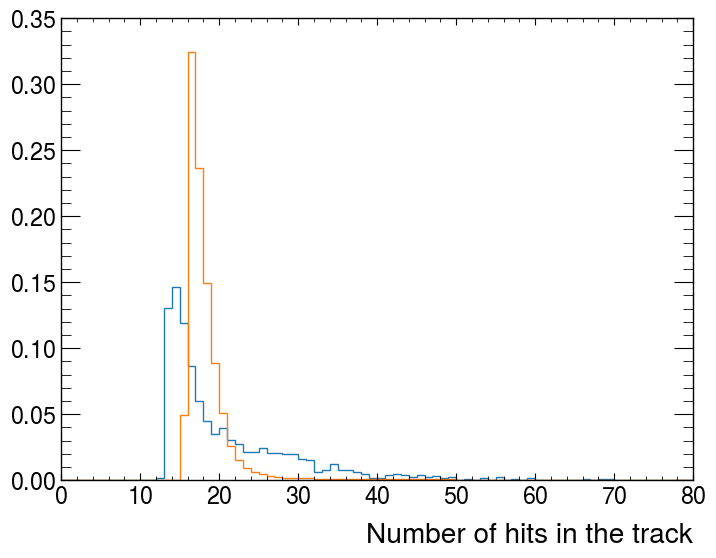

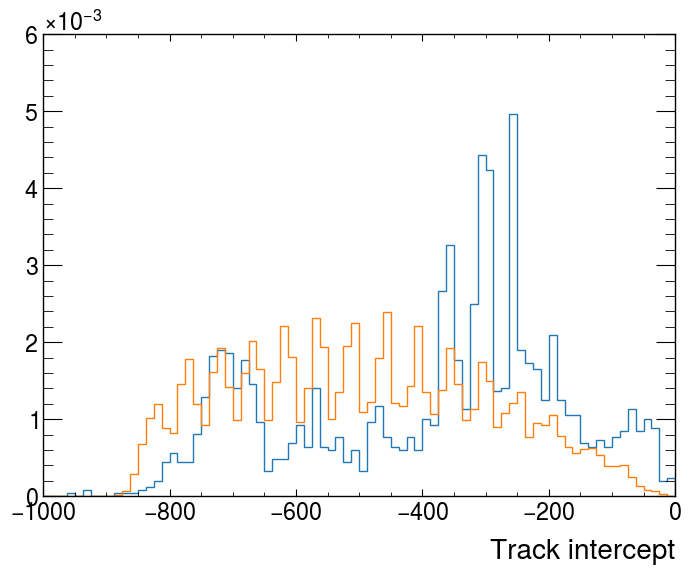

In [7]:
ar_3l = ar_skim[ar_skim['nTestHits']<3]  # less than 3 hits
ar_4e = ar_skim[ar_skim['nTestHits']==4] # equal to 4 hits

plt.hist(ar_3l['trackChi2']/(ar_3l['trackPoints']-2), histtype='step', density=True, range=(0, 100), bins=100);
plt.hist(ar_4e['trackChi2']/(ar_4e['trackPoints']-2), histtype='step', density=True, range=(0, 100), bins=100);
plt.xlabel("Chi2/NDF");

plt.figure()
plt.hist(ar_3l['trackPEs'], histtype='step', density=True, range=(1000, 5000), bins=100);
plt.hist(ar_4e['trackPEs'], histtype='step', density=True, range=(1000, 5000), bins=100);
plt.xlabel("Total PEs in the track");

plt.figure()
plt.hist(ar_3l['trackPoints'], histtype='step', density=True, range=(0, 80), bins=80);
plt.hist(ar_4e['trackPoints'], histtype='step', density=True, range=(0, 80), bins=80);
plt.xlabel("Number of hits in the track");

plt.figure()
plt.hist(ar_3l['trackIntercept'], histtype='step', density=True, range=(-1000, 0), bins=80);
plt.hist(ar_4e['trackIntercept'], histtype='step', density=True, range=(-1000, 0), bins=80);
plt.xlabel("Track intercept");

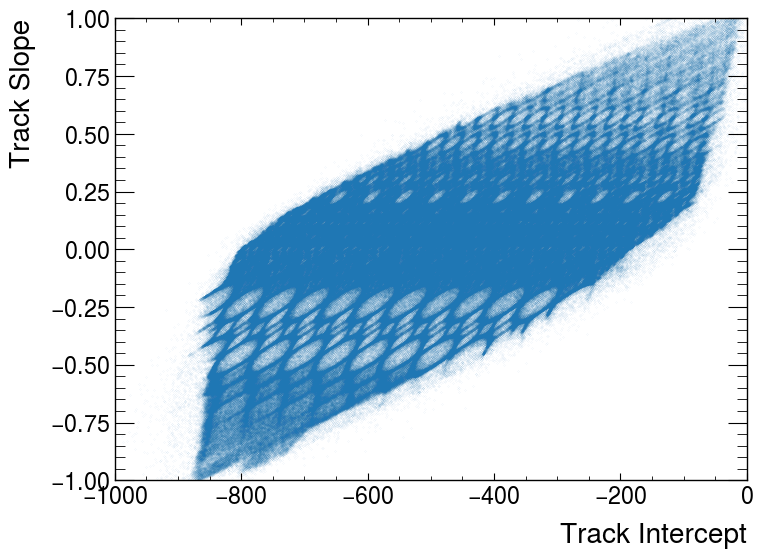

In [8]:
plt.plot(ar_4e['trackIntercept'], ar_4e['trackSlope'], '.', markersize=0.05);
#plt.plot(df.query(cuts_)['trackIntercept'], df.query(cuts_)['trackSlope'], '.r', markersize=1.5);
plt.ylim(-1,1)
plt.xlim(-1000,0);
plt.xlabel('Track Intercept')
plt.ylabel('Track Slope')


value_to_highlight = -250
#plt.axvline(value_to_highlight, color='green', linestyle='--')

value_to_highlight = -750
#plt.axvline(value_to_highlight, color='green', linestyle='--');

# Plot a line with a specific slope
slope = 0.5  # Adjust the slope as needed
x_values = np.arange(-800, -200)
y_values_line = slope * x_values
#plt.plot(x_values, y_values_line, label=f'Line with Slope {slope}', linestyle='--', color='green');


In [9]:
#cuts = 'trackChi2/(trackPoints-2)<30 & trackPoints < 30 & trackIntercept < -200 & trackIntercept > -750 & trackPEs < 3000'

# Cuts
chi2_per_point_limit = 30
intercept_lower_limit = -700
intercept_upper_limit = -200
trackPEs_limit = 3000
nTrigHits_limit = 12

# Define the cut conditions
condition_chi2 = (ar_skim["trackChi2"] / ar_skim["trackPoints"] - 2) < chi2_per_point_limit
condition_intercept = (ar_skim["trackIntercept"] > intercept_lower_limit) & (ar_skim["trackIntercept"] < intercept_upper_limit)
condition_trackPEs = ar_skim["trackPEs"] < trackPEs_limit
condition_nTrigHits = ar_skim["nTrigHits"] >= nTrigHits_limit

# Combine the conditions
cut = condition_chi2 & condition_intercept & condition_trackPEs & condition_nTrigHits

#Apply cuts
ar_3l = ar_skim[cut & (ar_skim['nTestHits']<3)]  # less than 3 hits
ar_4e = ar_skim[cut & (ar_skim['nTestHits']==4)] # equal to 4 hits

In [10]:
#Printout some events that fail 3-out-of-4
ak.to_dataframe(ar_3l).head(20)

spillNumber  eventNumber  runNumber  subrunNumber  \
entry subentry                                                      
0     0                   2          128       1720             0   
      1                   2          128       1720             0   
      2                   2          128       1720             0   
      3                   2          128       1720             0   
1     0                 342          206       1720             0   
      1                 342          206       1720             0   
      2                 342          206       1720             0   
      3                 342          206       1720             0   
2     0                  89          285       1721             0   
      1                  89          285       1721             0   
      2                  89          285       1721             0   
      3                  89          285       1721             0   
3     0                 173          267       1721             0   
      1                 173          267       1721             0   
      2                 173          267       1721             0   
      3                 173          267       1721             0   
4     0                 641          244       1721             1   
      1                 641          244       1721             1   
      2                 641          244       1721             1   
      3                 641          244       1721             1   

                   trackPEs  trackPoints   trackChi2  trackIntercept  \
entry subentry                                                         
0     0         1622.661377           14  226.464722     -465.041809   
      1         1622.661377           14  226.464722     -465.041809   
      2         1622.661377           14  226.464722     -465.041809   
      3         1622.661377           14  226.464722     -465.041809   
1     0         1874.265747           14  238.021027     -681.052368   
      1         1874.265747           14  238.021027     -681.052368   
      2         1874.265747           14  238.021027     -681.052368   
      3         1874.265747           14  238.021027     -681.052368   
2     0         1530.004272           14  246.222473     -680.241211   
      1         1530.004272           14  246.222473     -680.241211   
      2         1530.004272           14  246.222473     -680.241211   
      3         1530.004272           14  246.222473     -680.241211   
3     0         1738.969116           15  228.045349     -572.993164   
      1         1738.969116           15  228.045349     -572.993164   
      2         1738.969116           15  228.045349     -572.993164   
      3         1738.969116           15  228.045349     -572.993164   
4     0         1463.050171           16  205.382675     -469.453827   
      1         1463.050171           16  205.382675     -469.453827   
      2         1463.050171           16  205.382675     -469.453827   
      3         1463.050171           16  205.382675     -469.453827   

                trackSlope  nTrigHits  PEsTestLayers  nTestHits  
entry subentry                                                   
0     0           0.006006         12     113.189339          2  
      1           0.006006         12      86.975464          2  
      2           0.006006         12       0.000000          2  
      3           0.006006         12       0.000000          2  
1     0          -0.004784         12     235.199379          2  
      1          -0.004784         12       0.000000          2  
      2          -0.004784         12       0.000000          2  
      3          -0.004784         12      86.721962          2  
2     0          -0.001597         12     141.728760          2  
      1          -0.001597         12       0.000000          2  
      2          -0.001597         12       0.000000          2  
      3          -0.001597         12      86.361015  

In [11]:
eff = len(ar_3l)/len(ar_4e)
print("Efficiency at 10 PE: %.2e"%eff)

Efficiency at 10 PE: 5.48e-05


In [12]:
data_array = ar_3l['PEsTestLayers'].to_numpy()
df = pd.DataFrame(data_array, columns=[f'PEsTestLayers{i}' for i in range(1, data_array.shape[1] + 1)])

1577298


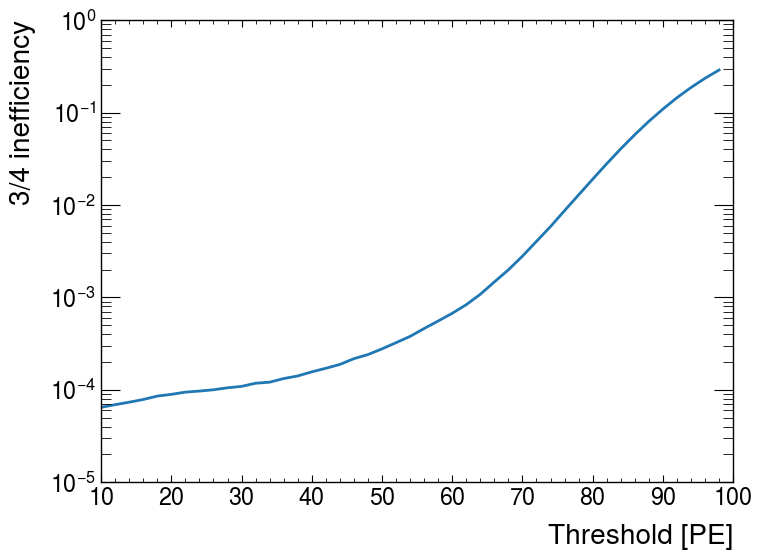

In [13]:
np_pe = ar_skim[cut]['PEsTestLayers'].to_numpy()
pe1 = np.sort(np_pe, axis=1)[:,1]
print(len(pe1))

threshold_range = range(10, 100, 2)
counts = []
# Loop through each threshold and count elements above it
for threshold in threshold_range:
    mask = pe1 > threshold
    count_above_threshold = np.sum(mask)
    counts.append(count_above_threshold)

plt.plot(threshold_range, 1-np.array(counts)/len(pe1), '-')
plt.xlabel('Threshold [PE]')
plt.ylabel('3/4 inefficiency')
plt.yscale('log')